# <div align="center">Word embeddings for sentiment analysis</div>
---------------------------------------------------------------------

you can Find me on Github:
> ###### [ GitHub](https://github.com/lev1khachatryan)

When applying one-hot encoding to words, we end up with sparse (containing many zeros) vectors of high dimensionality. On large data sets, this could cause performance issues. Additionally, one-hot encoding does not take into account the semantics of the words. So words like airplane and aircraft are considered to be two different features. While we know that they have a very similar meaning. Word embeddings address these two issues.

Word embeddings are dense vectors with much lower dimensionality. Secondly, the semantic relationships between words are reflected in the distance and direction of the vectors.

We will work with the TwitterAirlineSentiment data set on Kaggle. This data set contains roughly 15K tweets with 3 possible classes for the sentiment (positive, negative and neutral).

After reading this tutorial you will know how to compute task-specific word embeddings with the Embedding layer of Keras. Secondly, we will investigate whether word embeddings trained on a larger corpus can improve the accuracy of our model.

# <div align="center">The structure of this tutorial is:</div>
---------------------------------------------------------------------

* Intuition behind word embeddings


* Project set-up


* Data preparation


* Keras and its Embedding layer


* Pre-trained word embeddings — GloVe


* Training word embeddings with more dimensions

# <div align="center">Intuition behind word embeddings</div>
---------------------------------------------------------------------

Before we can use words in a classifier, we need to convert them into numbers. One way to do that is to simply map words to integers. Another way is to one-hot encode words. Each tweet could then be represented as a vector with a dimension equal to (a limited set of) the words in the corpus. The words occurring in the tweet have a value of 1 in the vector. All other vector values equal zero.

Word embeddings are computed differently. Each word is positioned into a multi-dimensional space. The number of dimensions in this space is chosen by the data scientist. You can experiment with different dimensions and see what provides the best result.

The vector values for a word represent its position in this embedding space. Synonyms are found close to each other while words with opposite meanings have a large distance between them. You can also apply mathematical operations on the vectors which should produce semantically correct results. A typical example is that the sum of the word embeddings of king and female produces the word embedding of queen.

# <div align="center">Project set-up</div>
---------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers

Using TensorFlow backend.


We define some parameters and paths used throughout the project. Most of them are self-explanatory. But others will be explained further in the code.

In [16]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
root = Path('C:/_Files/MyProjects/ASDS_2/DeepLearning/Tutorial_DeepLearning/')
# input_path = 'input/4/'
# ouput_path = 'output/4/'
# source_path = 'source/4/'
input_path = root / 'input/4/'
ouput_path = root / 'output/4/'
source_path = root / 'source/4/'

# <div align="center">Some helper functions</div>
---------------------------------------------------------------------

In [30]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

# <div align="center">Data preparation</div>
---------------------------------------------------------------------

## Reading the data and cleaning
We read in the CSV file with the tweets and apply a random shuffle on its indexes. After that, we remove stop words and @ mentions. A test set of 10% is split off to evaluate the model on new data.

In [35]:
df = pd.read_csv(input_path / 'Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

## Convert words into integers
With the Tokenizer from Keras, we convert the tweets into sequences of integers. We limit the number of words to the NB_WORDS most frequent words. Additionally, the tweets are cleaned with some filters, set to lowercase and split on spaces.

In [36]:
tk = Tokenizer(num_words=NB_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

## Equal length of sequences
Each batch needs to provide sequences of equal length. We achieve this with the pad_sequences method. By specifying maxlen, the sequences or padded with zeros or truncated.

In [37]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [39]:
X_train_seq_trunc[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 1074, 4286,   14,   10, 6053,    1,  314, 1029,  233,  615,
         34, 1787])

## Encoding the target variable
The target classes are strings which need to be converted into numeric vectors. This is done with the LabelEncoder from Sklearn and the to_categorical method from Keras.

In [40]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [47]:
print(np.unique(y_train_le))
print(y_train_oh)

[0 1 2]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


## Splitting off the validation set
From the training data, we split off a validation set of 10% to use during training.

In [48]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

# <div align="center">Modeling</div>
---------------------------------------------------------------------

## Keras and the Embedding layer
Keras provides a convenient way to convert each word into a multi-dimensional vector. This can be done with the Embedding layer. It will compute the word embeddings (or use pre-trained embeddings) and look up each word in a dictionary to find its vector representation. Here we will train word embeddings with 8 dimensions.

In [49]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(3, activation='softmax'))
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

W0714 15:24:35.324236  8168 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 15:24:35.372141  8168 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 15:24:35.382081  8168 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 15:24:35.429989  8168 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0714 15:24:35.443954  8168 deprecation_wrapper.py:119] From C:\ProgramData\Anac

In [53]:
emb_history.history['acc'][-1]

0.751644459396455

We have a validation accuracy of about 74%. The number of words in the tweets is rather low, so this result is rather good. By comparing the training and validation loss, we see that the model starts overfitting from epoch 6.

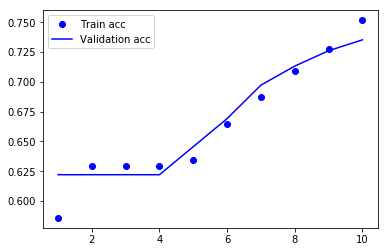

In [54]:
eval_metric(emb_history, 'acc')

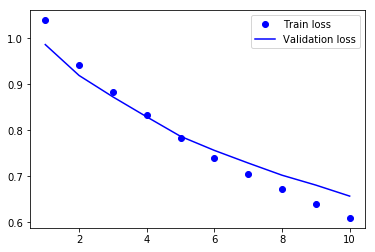

In [55]:
eval_metric(emb_history, 'loss')

When we train the model on all data (including the validation data, but excluding the test data) and set the number of epochs to 6, we get a test accuracy of 78%. This test result is quite ok, but let’s see if we can improve with pre-trained word embeddings.

In [56]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

1464/1464 [==============================] - 0s 13us/step
/n
Test accuracy of word embeddings model: 77.73%


## Pre-trained word embeddings — Glove
Because the training data is not so large, the model might not be able to learn good embeddings for the sentiment analysis. Alternatively, we can load pre-trained word embeddings built on a much larger training data.

The GloVe database contains multiple pre-trained word embeddings, and more specific embeddings trained on tweets. So this might be useful for the task at hand.

First, we put the word embeddings in a dictionary where the keys are the words and the values the word embeddings.

In [57]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(input_path / glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\_Files\\MyProjects\\ASDS_2\\DeepLearning\\Tutorial_DeepLearning\\input\\4\\glove.twitter.27B.100d.txt'